# Previsione della Qualità dell'Aria - **Allenamento con Dati Augmentati e Valutazione dei Modelli**

**Progetto di Data Intensive**  
**Autore:** Martin Tomassi, Jacopo Vasi  
**Email:** martin.tomassi@studio.unibo.it , jacopo.vasi@studio.unibo.it  
**Corso:** Data Intensive, Università di Bologna  
**Data:** Aprile 2025

## Caricamento dei Datasets ed Import Librerie



In [1]:
import os.path
from urllib.request import urlretrieve
import requests
import zipfile
import io
import glob
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_theme()

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_log_error,
    explained_variance_score,
    max_error
)
from sklearn.model_selection import (
    TimeSeriesSplit,
    RandomizedSearchCV,
    GridSearchCV,
    ParameterSampler
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet
)

import xgboost as xgb
from IPython.display import clear_output
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

%pip install xgboost
from xgboost import XGBRegressor

N_JOBS = -1
RANDOM_STATE = 42

Note: you may need to restart the kernel to use updated packages.


In [2]:
if running_in_colab:
    df = pd.read_csv('https://raw.githubusercontent.com/vMxster/Data_Project/main/Datasets/augmented_dataset.csv',
                 sep=',',
                 quotechar='"',
                 dtype=None,
                 parse_dates=True,
                 low_memory=False)
else:
    df = pd.read_csv('augmented_dataset.csv',
                     sep=',',
                     quotechar='"',
                     dtype=None,
                     parse_dates=True,
                     low_memory=False)


obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype("string")
df = df[(df['year'] >= 2020) & (df['year'] <= 2022)]
df = df.reset_index(drop=True)
df.head()

,year,month,dayofmonth,state,PM2.5,CO,O3,dayofweek,quarter,weekofyear,...,o3_lag_1Y,pm_lag_2Y,co_lag_2Y,o3_lag_2Y,pm_lag_1M,co_lag_1M,o3_lag_1M,pm_lag_1W,co_lag_1W,o3_lag_1W
0,2020,1,1,Madhya Pradesh,90.081692,0.913343,28.474670,2,1,1,...,63.127333,205.530417,1.355000,82.097708,80.834386,0.833265,52.997402,95.927965,0.837701,33.082604
1,2020,1,1,Telangana,40.587069,0.637917,28.698722,2,1,1,...,31.786597,57.492500,0.978417,39.430486,44.600486,0.610000,21.900069,71.744167,0.735000,34.434514
2,2020,1,1,Uttar Pradesh,297.640091,2.383276,20.390113,2,1,1,...,31.685147,256.078693,2.350186,21.805840,131.564711,1.380966,36.720730,166.373550,1.235140,14.403787
3,2020,1,1,Tamil Nadu,28.776333,0.563250,26.441354,2,1,1,...,56.341250,50.512778,0.000000,28.469167,21.982153,0.457937,22.081910,49.426875,0.819271,30.534444
4,2020,1,1,Bihar,250.718403,2.375313,23.546944,2,1,1,...,47.750833,248.338542,1.253194,25.368750,154.494167,1.688611,34.127569,164.204097,1.309479,23.852819


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25658 entries, 0 to 25657
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        25658 non-null  int64  
 1   month       25658 non-null  int64  
 2   dayofmonth  25658 non-null  int64  
 3   state       25658 non-null  string 
 4   PM2.5       25658 non-null  float64
 5   CO          25658 non-null  float64
 6   O3          25658 non-null  float64
 7   dayofweek   25658 non-null  int64  
 8   quarter     25658 non-null  int64  
 9   weekofyear  25658 non-null  int64  
 10  dayofyear   25658 non-null  int64  
 11  date        25658 non-null  string 
 12  pm_lag_1Y   21511 non-null  float64
 13  co_lag_1Y   21511 non-null  float64
 14  o3_lag_1Y   21511 non-null  float64
 15  pm_lag_2Y   19742 non-null  float64
 16  co_lag_2Y   19742 non-null  float64
 17  o3_lag_2Y   19742 non-null  float64
 18  pm_lag_1M   25328 non-null  float64
 19  co_lag_1M   25328 non-nul

# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei due dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `year`: anno della misurazione
- `month`: mese dell’anno
- `dayofmonth`: giorno del mese
- `dayofweek`: giorno della settimana
- `dayofyear`: giorno dell’anno
- `weekofyear`: settimana dell’anno
- `quarter`: trimestre dell’anno
- `state`: stato di misurazione
- `pm_lag_1W`: PM2.5 ritardato di 1 settimana
- `pm_lag_1M`: PM2.5 ritardato di 1 mese
- `pm_lag_1Y`: PM2.5 ritardato di 1 anno
- `pm_lag_2Y`: PM2.5 ritardato di 2 anni
- `co_lag_1W`: CO ritardato di 1 settimana
- `co_lag_1M`: CO ritardato di 1 mese
- `co_lag_1Y`: CO ritardato di 1 anno
- `co_lag_2Y`: CO ritardato di 2 anni
- `o3_lag_1W`: O3 ritardato di 1 settimana
- `o3_lag_1M`: O3 ritardato di 1 mese
- `o3_lag_1Y`: O3 ritardato di 1 anno
- `o3_lag_2Y`: O3 ritardato di 2 anni

La variabile dipendente target dell'addestramento è `PM2.5`, che indica la concentrazione di particelle inquinanti nell'aria con un diametro inferiore a 2,5 micron (μm).

## Preparazione Dataset
Per garantire un confronto equo tra tutti i modelli, alcuni dei quali non supportano i valori mancanti generati dalle lag features, elimineremo tutte le righe che li contengono. Va però tenuto presente che così facendo perdiamo un anno di dati storici. Modelli come XGBoost di scikit-learn sono in grado di gestire internamente i missing value e potrebbero beneficiarne; tuttavia, per mantenere omogenee le condizioni di allenamento, applichiamo il drop completo dei NaN.

In [4]:
target = 'PM2.5'
lag_features = ['pm_lag_1Y', 'pm_lag_2Y', 'pm_lag_1M', 'pm_lag_1W','co_lag_1Y', 'co_lag_2Y', 'co_lag_1M', 'co_lag_1W','o3_lag_1Y', 'o3_lag_2Y', 'o3_lag_1M', 'o3_lag_1W']
date_features = ['dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year', 'state']
predictors = date_features + lag_features

In [5]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    dataframe = dataframe.copy()

    if replace_na and method == 'zeros':
      dataframe = dataframe.fillna(0)
    elif replace_na and method == 'drop':
      dataframe = dataframe.dropna(how='any')

    train_set, test_set = np.split(dataframe, [int(len(dataframe) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [6]:
X_train, X_test, y_train, y_test = create_train_test_sets(
    df,
    split=0.8,
    replace_na=True,
    method='drop'
)

# Resetta gli indici dei risultati di create_train_test_sets eliminando l’indice precedente,
# in modo da partire da zero e avere indici continui
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

C:\Users\jacop\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15793 entries, 0 to 15792
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dayofmonth  15793 non-null  int64  
 1   dayofweek   15793 non-null  int64  
 2   dayofyear   15793 non-null  int64  
 3   weekofyear  15793 non-null  int64  
 4   month       15793 non-null  int64  
 5   quarter     15793 non-null  int64  
 6   year        15793 non-null  int64  
 7   state       15793 non-null  string 
 8   pm_lag_1Y   15793 non-null  float64
 9   pm_lag_2Y   15793 non-null  float64
 10  pm_lag_1M   15793 non-null  float64
 11  pm_lag_1W   15793 non-null  float64
 12  co_lag_1Y   15793 non-null  float64
 13  co_lag_2Y   15793 non-null  float64
 14  co_lag_1M   15793 non-null  float64
 15  co_lag_1W   15793 non-null  float64
 16  o3_lag_1Y   15793 non-null  float64
 17  o3_lag_2Y   15793 non-null  float64
 18  o3_lag_1M   15793 non-null  float64
 19  o3_lag_1W   15793 non-nul

In [8]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3949 entries, 0 to 3948
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dayofmonth  3949 non-null   int64  
 1   dayofweek   3949 non-null   int64  
 2   dayofyear   3949 non-null   int64  
 3   weekofyear  3949 non-null   int64  
 4   month       3949 non-null   int64  
 5   quarter     3949 non-null   int64  
 6   year        3949 non-null   int64  
 7   state       3949 non-null   string 
 8   pm_lag_1Y   3949 non-null   float64
 9   pm_lag_2Y   3949 non-null   float64
 10  pm_lag_1M   3949 non-null   float64
 11  pm_lag_1W   3949 non-null   float64
 12  co_lag_1Y   3949 non-null   float64
 13  co_lag_2Y   3949 non-null   float64
 14  co_lag_1M   3949 non-null   float64
 15  co_lag_1W   3949 non-null   float64
 16  o3_lag_1Y   3949 non-null   float64
 17  o3_lag_2Y   3949 non-null   float64
 18  o3_lag_1M   3949 non-null   float64
 19  o3_lag_1W   3949 non-null  

Nel dataset ci sono sia feature numeriche che categoriche. <br>
Per le numeriche è necessario applicare una normalizzazione dei dati, i quali avrebbero altrimenti valori su scale molto diverse che renderebbero più difficile la convergenza del modello. <br>
Per poter utilizzare le variabili categoriche nell'addestramento di un modello di regressione si usa un OneHotEncoder, creando nuove colonne binarie per ciascuno dei valori ammissibili dalla variabile categorica.

In [9]:
categorical_features = X.select_dtypes(include=["string"]).columns.tolist()
numerical_features   = [c for c in X.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    # Standardizza tutte le colonne numeriche
    ("numeric",    StandardScaler(),    numerical_features),
    # One‑hot encoding di 'state', ignorando nuovi stati in predict
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

Inizializzazione della lista per raccogliere le metriche dopo ogni training

In [10]:
all_scores = []

## Valutazione delle Prestazioni dei Modelli Allenati

Dopo l'allenamento di ciascun modello di Machine Learning e Deep Learning, utilizziamo la funzione `get_estimator_scores` e `get_torch_estimator_scores` per calcolare diverse metriche di valutazione, includendo per le principali anche gli **Intervalli di Confidenza al 95%** (CI95%) stimati tramite bootstrap resampling.

Le metriche calcolate sono:

1. **$R^2$ (Coefficiente di Determinazione)**  
   Misura quanto bene un modello riesce a spiegare la variabilità della variabile dipendente. Il valore di $R^2$ varia da 0 (nessuna capacità predittiva) a 1 (predizione perfetta).  
   Un $R^2_{\text{test}}$ significativamente inferiore rispetto a $R^2_{\text{train}}$ indica possibile overfitting.  
   *(Più alto è, meglio è.)*

2. **Root Mean Squared Error (RMSE)**  
   Misura la deviazione standard degli errori di previsione (la radice quadrata del MSE). Penalizza maggiormente gli errori più grandi.  
   *(Più basso è, meglio è.)*

3. **Mean Absolute Error (MAE)**  
   Rappresenta la media delle differenze assolute tra i valori reali e quelli predetti. È meno sensibile agli outlier rispetto all’RMSE.  
   *(Più basso è, meglio è.)*

4. **Mean Absolute Percentage Error (MAPE)**  
   Misura la precisione percentuale di un sistema di previsione. Indica, in media, quanto si discosta una previsione rispetto al valore reale.  
   *(Più basso è, meglio è.)*

5. **Mean Squared Logarithmic Error (MSLE)**  
   Utile quando si vuole penalizzare maggiormente gli errori relativi per valori piccoli e avere tolleranza su valori grandi.  
   *(Più basso è, meglio è.)*

6. **Explained Variance Score**  
   Misura la proporzione della varianza spiegata dal modello, simile a $R^2$, ma può essere più informativo in caso di regressione non lineare.  
   *(Più alto è, meglio è.)*

7. **Max Error**  
   Misura l’errore assoluto massimo commesso in una previsione.  
   *(Più basso è, meglio è.)*


In [11]:
def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    for _ in range(n_bootstraps):
        if running_in_colab:
            idx = np.random.randint(0, len(y_true), len(y_true))
            vals.append(metric_fn(y_true[idx], y_pred[idx]))
        else:
            idx = np.random.randint(0, len(y_true), len(y_true))
            vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx]))

    low = np.percentile(vals, 100 * (alpha/2))
    high = np.percentile(vals, 100 * (1 - alpha/2))
    return low, high

def get_estimator_scores(model_name, model):
    y_pred = model.predict(X_test)
    r2_tr = model.score(X_train, y_train)
    r2_te = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    msle = mean_squared_log_error(y_test, np.maximum(y_pred, 0))
    evs = explained_variance_score(y_test, y_pred)
    me = max_error(y_test, y_pred)

    rmse_low, rmse_high = bootstrap_ci(lambda a,b: np.sqrt(mean_squared_error(a, b)), y_test, y_pred)
    mae_low, mae_high = bootstrap_ci(mean_absolute_error, y_test, y_pred)
    mape_low, mape_high = bootstrap_ci(mean_absolute_percentage_error, y_test, y_pred)

    all_scores.append([
        model_name, r2_tr, r2_te,
        rmse, rmse_low, rmse_high,
        mae, mae_low, mae_high,
        mape, mape_low, mape_high,
        msle, evs, me
    ])

def predict_torch(model, X_tensor, device):
    model.eval()
    with torch.no_grad():
        out = model(X_tensor.to(device))
    out_cpu = out.detach().cpu().numpy()
    # Se il modello restituisce shape (N,1), appiattiamo a (N,)
    if out_cpu.ndim == 2 and out_cpu.shape[1] == 1:
        return out_cpu.ravel()
    return out_cpu

def get_torch_estimator_scores(model_name, model,
                               X_train, y_train,
                               X_test, y_test,
                               device):
    y_pred_train = predict_torch(model, X_train, device)
    y_pred_test  = predict_torch(model, X_test,  device)

    y_train_np = y_train.detach().cpu().numpy().ravel()
    y_test_np  = y_test.detach().cpu().numpy().ravel()

    r2_tr = r2_score(y_train_np, y_pred_train)
    r2_te = r2_score(y_test_np,  y_pred_test)

    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_test))
    rmse_low, rmse_high = bootstrap_ci(
        lambda a, b: np.sqrt(mean_squared_error(a, b)),
        y_test_np, y_pred_test
    )

    mae = mean_absolute_error(y_test_np, y_pred_test)
    mae_low, mae_high = bootstrap_ci(mean_absolute_error, y_test_np, y_pred_test)
    mape = mean_absolute_percentage_error(y_test_np, y_pred_test)
    mape_low, mape_high = bootstrap_ci(mean_absolute_percentage_error,
                                       y_test_np, y_pred_test)
    msle = mean_squared_log_error(y_test_np, np.maximum(y_pred_test, 0))
    evs = explained_variance_score(y_test_np, y_pred_test)
    me = max_error(y_test_np, y_pred_test)

    all_scores.append([
        model_name, r2_tr, r2_te,
        rmse, rmse_low, rmse_high,
        mae, mae_low, mae_high,
        mape, mape_low, mape_high,
        msle, evs, me
    ])

## Regressione lineare
Il modello più semplice da addestrare è la regressione lineare, senza filtri polinomiali o regolarizzazioni. Grazie all'elevato numero di dati usato per l'addestramento, si possono ottenere degli ottimi risultati, anche se migliorabili, già con questo primo modello.

In [12]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , LinearRegression())
])

In [13]:
%time model.fit(X_train, y_train)
get_estimator_scores("lin_reg", model)

CPU times: total: 250 ms
Wall time: 125 ms


## Regressione polinomiale
Per provare ad ottenere risultati migliori, vengono introdotte le feature polinomiali, che aggiungono nuove feature di grado superiore. Si esclude il bias, che consiste nel valore dell'intercetta, e si escludono i prodotti tra le diverse feature, per esempio i doppi prodotti in una regressione polinomiale di grado 2.

In [87]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr"   , LinearRegression())
])

In [88]:
%time model.fit(X_train, y_train)
get_estimator_scores("poly_reg", model)

CPU times: total: 156 ms
Wall time: 63.8 ms


## Regressione LASSO
La regressione LASSO è un'ottima tecnica per selezionare le feature più importanti, poichè la discesa del gradiente si ferma su un vertice di un ipercubo centrato sull'origine, quindi azzera i parametri delle variabili meno rilevanti.

In [16]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr", Lasso(alpha=1, max_iter=10000))
])

In [17]:
%time model.fit(X_train, y_train)

CPU times: total: 219 ms
Wall time: 285 ms


,steps,"[('preproc', ...), ('regr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
tscv = TimeSeriesSplit(n_splits=5)

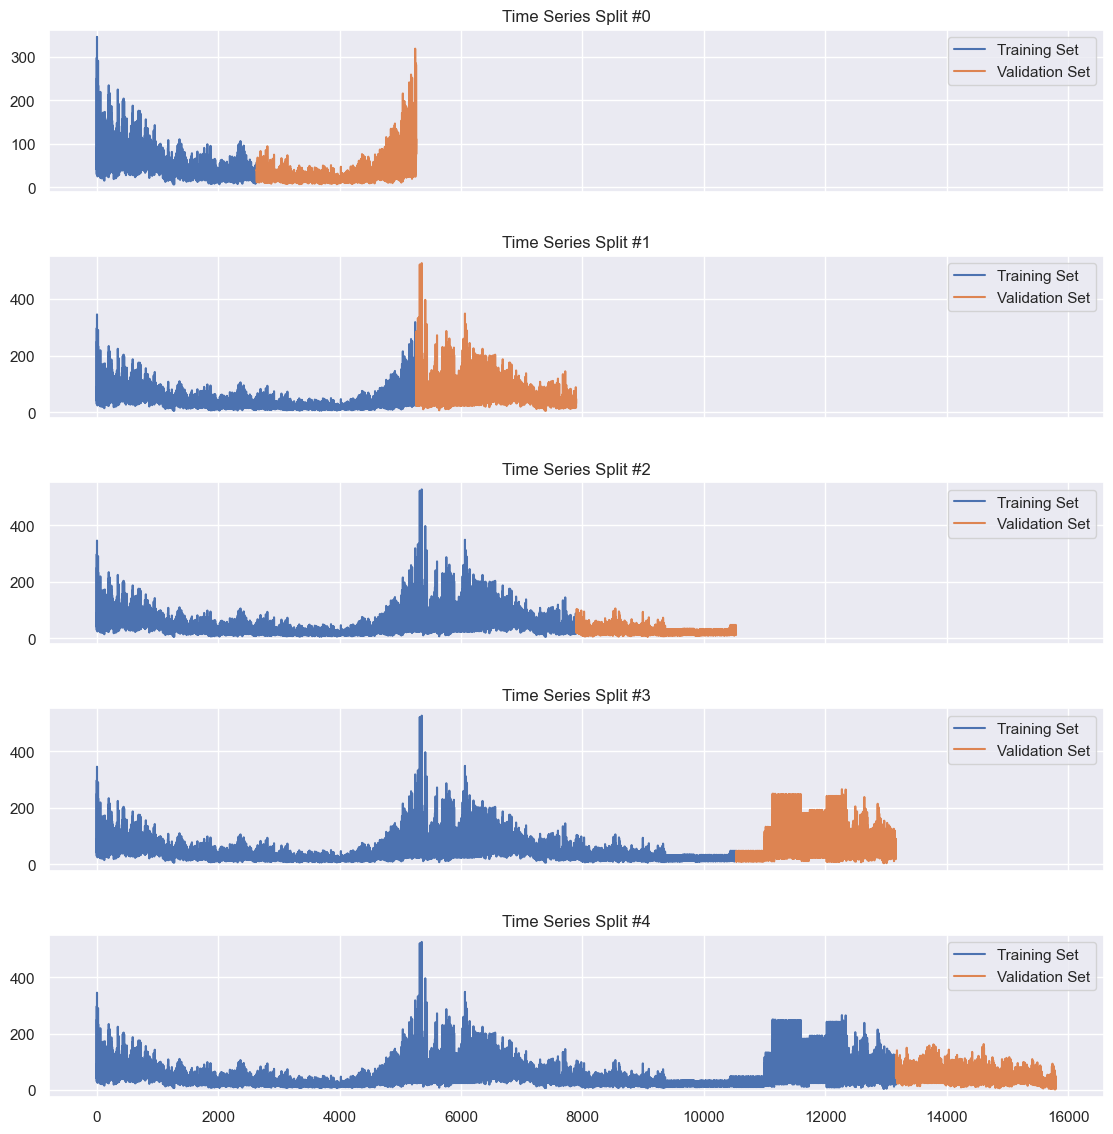

In [19]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)):
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

plt.show()

In [20]:
alphas = np.logspace(-3, 1, num=5)
grid = {"regr__alpha": alphas}
gs = RandomizedSearchCV(model, grid, n_iter=5, cv=tscv, n_jobs=N_JOBS)

In [21]:
%time gs.fit(X_train, y_train);
print()

CPU times: total: 484 ms
Wall time: 17.3 s



In [22]:
get_estimator_scores("lasso_reg", gs.best_estimator_)

In [23]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha", "mean_test_score"]]

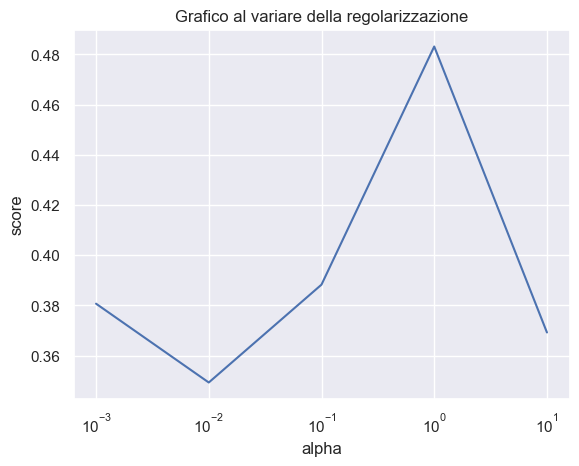

In [24]:
plt.plot(results["param_regr__alpha"], results["mean_test_score"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Grafico al variare della regolarizzazione')
plt.show()

## Regressione Ridge
Proviamo la regolarizzazione con feature polinomiali per ridurre un eventuale overfitting.

In [25]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", Ridge(alpha=1, max_iter=10000))
])

In [26]:
%time model.fit(X_train, y_train)

CPU times: total: 1.14 s
Wall time: 395 ms


,steps,"[('preproc', ...), ('poly', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
alphas = np.logspace(-2, 8, num=12)
grid = {"regr__alpha": alphas}
gs = RandomizedSearchCV(model, grid, n_iter=12, cv=tscv, n_jobs=N_JOBS)

In [28]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 1.38 s
Wall time: 3.89 s



In [29]:
get_estimator_scores("ridge_reg", gs.best_estimator_)

In [30]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha", "mean_test_score"]]

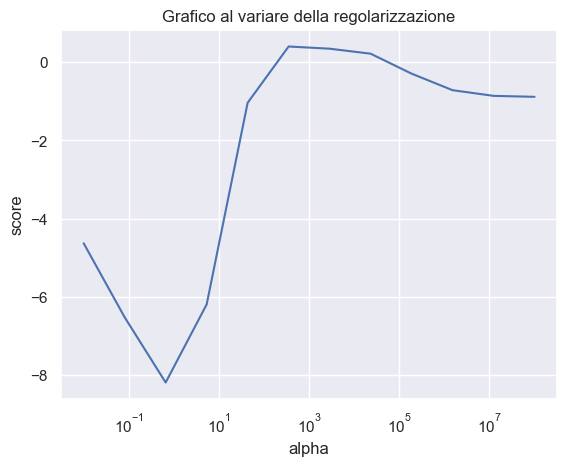

In [31]:
plt.plot(results["param_regr__alpha"], results["mean_test_score"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Grafico al variare della regolarizzazione')
plt.show()

## Regressione Elastic Net
Questa regressione unisce la regolarizzazione LASSO e la regolarizzazione Ridge.

In [32]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", ElasticNet(alpha=0.2, l1_ratio=0.1))
])

In [33]:
%time model.fit(X_train, y_train)

CPU times: total: 1min 16s
Wall time: 46.4 s


,steps,"[('preproc', ...), ('poly', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__l1_ratio": [0.1, 0.2, 0.3]
}
gs = RandomizedSearchCV(model, grid, n_iter=9, cv=tscv, n_jobs=N_JOBS)

In [35]:
%time gs.fit(X_train, y_train);
print()

CPU times: total: 1min 52s
Wall time: 1min 26s



In [36]:
get_estimator_scores("elastic_net_reg", gs.best_estimator_)

## Regressione con funzioni kernel
Per ovviare ai problemi di prestazioni dei modelli con feature polinomiali, usiamo il kernel trick per evitare di creare un numero elevato di feature aggiuntive.

## Funzioni kernel polinomiali

In [37]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr",  KernelRidge(alpha=1, kernel="poly", degree=10))
])

In [38]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 1min 46s
Wall time: 33.7 s



In [39]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__degree": list(range(2,30))
}
gs = RandomizedSearchCV(model, grid, n_iter=20, cv=tscv, n_jobs=N_JOBS)

In [40]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 1min 42s
Wall time: 5min 49s



In [41]:
get_estimator_scores("kernel_poly_reg", gs.best_estimator_)

In [42]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha","param_regr__degree","mean_test_score"]]
results_0_1 = results[results["param_regr__alpha"] == 0.1]
results_1 = results[results["param_regr__alpha"] == 1]
results_10 = results[results["param_regr__alpha"] == 10]

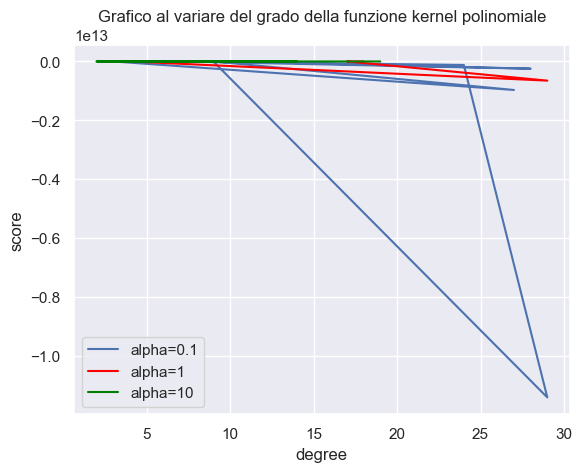

In [43]:
plt.plot(results_0_1["param_regr__degree"], results_0_1["mean_test_score"])
plt.plot(results_1["param_regr__degree"], results_1["mean_test_score"], c="red")
plt.plot(results_10["param_regr__degree"], results_10["mean_test_score"], c="green")
plt.xlabel('degree')
plt.ylabel('score')
plt.legend(["alpha=0.1","alpha=1","alpha=10"])
plt.title('Grafico al variare del grado della funzione kernel polinomiale')
plt.show()

## Funzioni kernel gaussiane

Testiamo anche funzioni kernel diverse, ad esempio RBF (_radial basis function_). <br>
La funzione RBF ha la forma di una gaussiana.

In [44]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr",  KernelRidge(alpha=1, kernel="rbf", gamma=0.01))
])

In [45]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 1min 42s
Wall time: 29.1 s



In [46]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__gamma": [0.01, 0.1, 1]
}
gs = RandomizedSearchCV(model, grid, n_iter=9, cv=tscv, n_jobs=N_JOBS)

In [47]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 1min 42s
Wall time: 3min



In [48]:
get_estimator_scores("kernel_rbf_reg", gs.best_estimator_)

## Alberi decisionali

In [49]:
model = Pipeline([
    ("preproc", preprocessor),
    ("tree", DecisionTreeRegressor(max_depth=4, random_state=42))
])

In [50]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 203 ms
Wall time: 283 ms



In [53]:
grid = {
    "tree__max_depth": list(range(4,30)),
    "tree__min_samples_split": [0.005, 0.01, 0.1, 0.15],
}
gs = RandomizedSearchCV(model, grid, n_iter=24, cv=tscv, n_jobs=N_JOBS)
grid = {
    "tree__max_depth": list(range(4,30)),
    "tree__min_samples_split": [0.005, 0.01, 0.1, 0.15],
}
gs = RandomizedSearchCV(model, grid, n_iter=24, cv=tscv, n_jobs=N_JOBS)

In [54]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 844 ms
Wall time: 8.21 s



In [55]:
get_estimator_scores("decision_tree_reg", gs.best_estimator_)

In [56]:
results = pd.DataFrame(gs.cv_results_)[[
    "param_tree__min_samples_split",
    "param_tree__max_depth",
    "mean_test_score"
]]
splits = sorted(results["param_tree__min_samples_split"].unique())

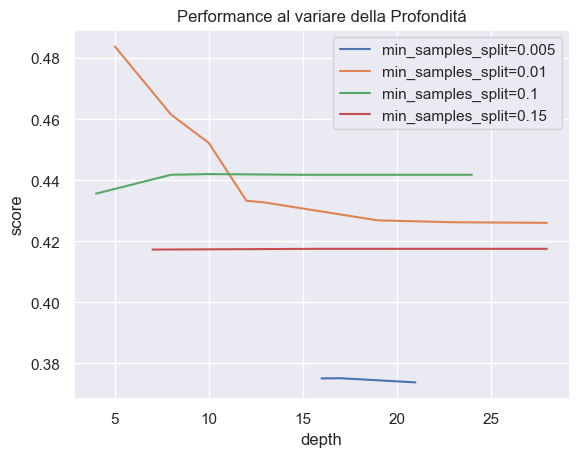

In [57]:
for split in splits:
    subset = results[results["param_tree__min_samples_split"] == split]
    subset = subset.sort_values("param_tree__max_depth")
    plt.plot(
        subset["param_tree__max_depth"],
        subset["mean_test_score"],
        label=f"min_samples_split={split}"
    )

plt.xlabel('depth')
plt.ylabel('score')
plt.title("Performance al variare della Profonditá")
plt.legend()
plt.show()

## Random forest

In [58]:
model = Pipeline([
    ("preproc", preprocessor),
    ("tree", RandomForestRegressor(max_samples=0.2, max_features="sqrt", n_estimators=200, max_depth=None, n_jobs=-1))
])

In [59]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 5.91 s
Wall time: 747 ms



Possiamo ricavare le 10 feature più importanti per la Random Forest, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [60]:
pd.Series(model.named_steps["tree"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1W     0.222888
numeric__pm_lag_1Y     0.121618
numeric__pm_lag_2Y     0.094965
numeric__pm_lag_1M     0.091392
numeric__co_lag_1W     0.061116
numeric__dayofyear     0.056868
numeric__weekofyear    0.038276
numeric__month         0.036526
numeric__co_lag_1Y     0.035300
numeric__co_lag_2Y     0.033996
dtype: float64

In [61]:
grid = {
    "tree__n_estimators": [150, 200, 250, 300],
    "tree__max_samples": [0.5, 0.6, 0.8, 1.0],
}
gs = RandomizedSearchCV(model, grid, n_iter=16, cv=tscv, n_jobs=N_JOBS)

In [62]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 1min 10s
Wall time: 1min 48s



In [63]:
get_estimator_scores("random_forest_reg", gs.best_estimator_)

In [64]:
results = pd.DataFrame(gs.cv_results_)[["param_tree__n_estimators","param_tree__max_samples","mean_test_score"]]
results_0_5 = results[results["param_tree__max_samples"] == 0.5]
results_0_6 = results[results["param_tree__max_samples"] == 0.6]
results_0_8 = results[results["param_tree__max_samples"] == 0.8]
results_1 = results[results["param_tree__max_samples"] == 1.0]

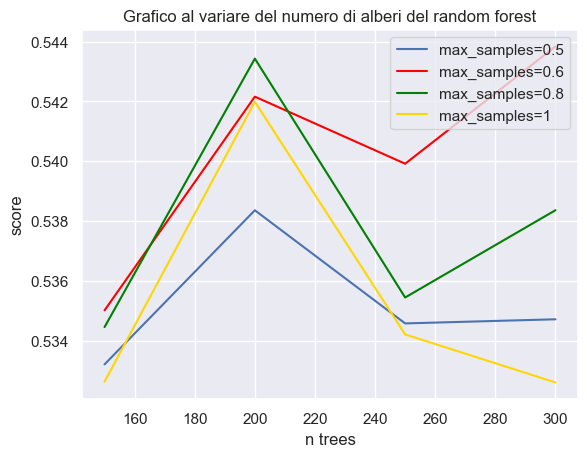

In [65]:
plt.plot(results_0_5["param_tree__n_estimators"], results_0_5["mean_test_score"])
plt.plot(results_0_6["param_tree__n_estimators"], results_0_6["mean_test_score"], c="red")
plt.plot(results_0_8["param_tree__n_estimators"], results_0_8["mean_test_score"], c="green")
plt.plot(results_1["param_tree__n_estimators"], results_1["mean_test_score"], c="gold")
plt.xlabel('n trees')
plt.ylabel('score')
plt.legend(["max_samples=0.5","max_samples=0.6","max_samples=0.8","max_samples=1"])
plt.title('Grafico al variare del numero di alberi del random forest')
plt.show()

## XGBoost
XGBoost crea una foresta di alberi in cui ogni albero utilizza gli errori commessi dall'albero precedente.

In [66]:
model = Pipeline([
    ("preproc", preprocessor),
    ("xgb", XGBRegressor(objective='reg:squarederror', n_estimators=200))
])

In [67]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 6.45 s
Wall time: 648 ms



Possiamo ricavare le 5 feature più importanti per XGBoost, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [68]:
pd.Series(model.named_steps["xgb"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(5)

numeric__pm_lag_1W                  0.390422
categorical__state_Delhi            0.065693
numeric__weekofyear                 0.059039
categorical__state_Uttar Pradesh    0.033390
numeric__dayofyear                  0.030644
dtype: float32

In [69]:
grid = {
    "xgb__max_depth": [3, 5, 7, 10],
    "xgb__n_estimators": [100, 200, 400, 700, 1000],
}
gs = RandomizedSearchCV(model, grid, n_iter=20, cv=tscv, n_jobs=N_JOBS)

In [70]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 29.3 s
Wall time: 52.8 s



In [71]:
get_estimator_scores("xgboost_reg", gs.best_estimator_)

In [72]:
results = pd.DataFrame(gs.cv_results_)[["param_xgb__max_depth","param_xgb__n_estimators","mean_test_score"]]
results_3 = results[results["param_xgb__max_depth"] == 3]
results_5 = results[results["param_xgb__max_depth"] == 5]
results_7 = results[results["param_xgb__max_depth"] == 7]
results_10 = results[results["param_xgb__max_depth"] == 10]

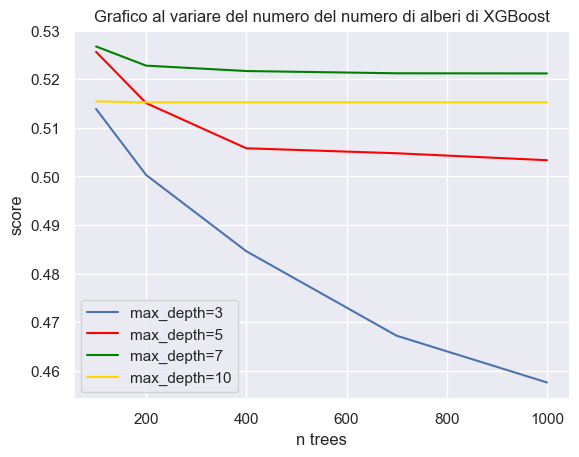

In [73]:
plt.plot(results_3["param_xgb__n_estimators"], results_3["mean_test_score"])
plt.plot(results_5["param_xgb__n_estimators"], results_5["mean_test_score"], c="red")
plt.plot(results_7["param_xgb__n_estimators"], results_7["mean_test_score"], c="green")
plt.plot(results_10["param_xgb__n_estimators"], results_10["mean_test_score"], c="gold")
plt.xlabel('n trees')
plt.ylabel('score')
plt.legend(["max_depth=3","max_depth=5","max_depth=7","max_depth=10"])
plt.title('Grafico al variare del numero del numero di alberi di XGBoost')
plt.show()

## MLP

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout):
        super().__init__()
        layers = []
        dim = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

Device utilizzato: cpu


### Random Search con Early Stopping

Questo blocco di codice implementa una procedura completa di **Random Search** per la selezione di iperparametri di modelli di regressione in PyTorch, integrando una strategia di **Early Stopping** per migliorare l'efficienza del training.

* La classe `EarlyStopper` consente di interrompere l'addestramento anticipatamente se la loss di validazione non migliora per un numero di epoche definito (`patience`), riducendo il rischio di overfitting e velocizzando l'ottimizzazione.
* Le funzioni `train_epoch` ed `eval_loss` gestiscono rispettivamente il training e la valutazione della loss media su un dataset.
* La funzione principale `random_search` esegue una **Cross-Validation**, dove:
  * Il ciclo valuta le prestazioni generali del modello su diversi split train/test.

In [89]:
from sklearn.model_selection import train_test_split

class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            total_loss += criterion(model(Xb), yb).item() * Xb.size(0)
    return total_loss / len(loader.dataset)



def random_search(model_builder, param_dist, dataset,
                  n_iter=10,
                  val_ratio=0.2,
                  early_patience=5,
                  early_min_delta=1e-4):
    train_keys = ['lr', 'batch_size', 'max_epochs']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    # Hold-out split
    train_idx, val_idx = train_test_split(range(len(dataset)), test_size=val_ratio, shuffle=False)
    sub_train = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)

    print("Avvio Random Search con Hold-Out Validation...")

    for param_id, params in enumerate(ParameterSampler(param_dist, n_iter=n_iter, random_state=RANDOM_STATE)):
        print(f"\nTesting parameter set {param_id+1}/{n_iter}")

        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}

        train_loader = DataLoader(sub_train, batch_size=train_params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_set, batch_size=train_params['batch_size'], shuffle=False)

        model = model_builder(**model_params).to(device)
        optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
        stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

        for epoch in range(train_params['max_epochs']):
            train_epoch(model, train_loader, optimizer, nn.MSELoss())
            val_loss = eval_loss(model, val_loader, nn.MSELoss())

            if epoch % 10 == 0:
                print(f"    Epoch {epoch}: val_loss = {val_loss:.6f}")

            if stopper.early_stop(val_loss):
                print(f"    Early stopping at epoch {epoch}")
                break

        final_val_loss = eval_loss(model, val_loader, nn.MSELoss())
        print(f"  Final validation loss: {final_val_loss:.6f}")

        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_model_params = model_params
            best_train_params = train_params
            best_model = model
            print(f"  New best validation loss: {best_val_loss:.6f}")

    print(f"\nBest validation loss: {best_val_loss:.6f}")
    return best_model, best_model_params, best_train_params


### Esecuzione del Random Search su MLP

In questa sezione viene eseguita la **ricerca di iperparametri tramite Random Search** per **MLP (Multi-Layer Perceptron)**.

#### Definizione degli spazi degli iperparametri:

* `mlp_param_dist`: contiene combinazioni di dimensioni dei layer nascosti, tassi di dropout, learning rate, batch size e numero massimo di epoche per il training del modello MLP.


In [90]:
from sklearn.preprocessing import LabelEncoder

X["state"] = LabelEncoder().fit_transform(X["state"])


In [91]:
print(X.dtypes)


dayofmonth      int64
dayofweek       int64
dayofyear       int64
weekofyear      int64
month           int64
quarter         int64
year            int64
state           int64
pm_lag_1Y     float64
pm_lag_2Y     float64
pm_lag_1M     float64
pm_lag_1W     float64
co_lag_1Y     float64
co_lag_2Y     float64
co_lag_1M     float64
co_lag_1W     float64
o3_lag_1Y     float64
o3_lag_2Y     float64
o3_lag_1M     float64
o3_lag_1W     float64
dtype: object


In [92]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

# (Training + Validation) Dataset
full_dataset = TensorDataset(X_tensor, y_tensor)

input_dim = X_tensor.shape[1]
mlp_param_dist = {
    'input_dim': [input_dim],
    'hidden_sizes': [(32,32), (64,64), (128,)],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'max_epochs': [50]
}
best_model, model_params, train_params = random_search(
    lambda **p: MLP(**p), mlp_param_dist, full_dataset
)

X_train_tensor = torch.stack([full_dataset[i][0] for i in range(len(full_dataset))])
y_train_tensor = torch.stack([full_dataset[i][1] for i in range(len(full_dataset))])
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

get_torch_estimator_scores("MLP", best_model,
                           X_train_tensor.to(device), y_train_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device)

Avvio Random Search con Hold-Out Validation...

Testing parameter set 1/10
    Epoch 0: val_loss = 888.171056
    Epoch 10: val_loss = 480.539025
    Epoch 20: val_loss = 443.655445
    Epoch 30: val_loss = 433.526438
    Epoch 40: val_loss = 429.314942
    Early stopping at epoch 49
  Final validation loss: 430.415893
  New best validation loss: 430.415893

Testing parameter set 2/10
    Epoch 0: val_loss = 2062.672316
    Epoch 10: val_loss = 1132.839395
    Epoch 20: val_loss = 860.610072
    Epoch 30: val_loss = 713.558790
    Early stopping at epoch 31
  Final validation loss: 758.369467

Testing parameter set 3/10
    Epoch 0: val_loss = 675.881215
    Epoch 10: val_loss = 438.393099
    Epoch 20: val_loss = 501.338002
    Early stopping at epoch 23
  Final validation loss: 516.695263

Testing parameter set 4/10
    Epoch 0: val_loss = 1280.943544
    Early stopping at epoch 9
  Final validation loss: 670.288267

Testing parameter set 5/10
    Epoch 0: val_loss = 503.670757
    E

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

# Confronto Visivo delle Prestazioni dei Modelli

La funzione `plot_estimator_scores(scores)` consente di visualizzare in modo sintetico ed intuitivo le metriche di valutazione di tutti i modelli allenati. I grafici generati permettono un confronto diretto tra le prestazioni su diverse metriche chiave:

- **R² Score**: confronta le prestazioni sul training set e sul test set per identificare possibili fenomeni di overfitting.
- **RMSE (Root Mean Squared Error)**: evidenzia la variabilità degli errori di previsione, penalizzando fortemente gli outlier.
- **MAE (Mean Absolute Error)**: mostra la media dell’errore assoluto commesso da ciascun modello.
- **MAPE (Mean Absolute Percentage Error)**: fornisce un’indicazione dell’errore medio in termini percentuali rispetto ai valori reali.
- **MSLE (Mean Squared Logarithmic Error)**: utile nei casi in cui gli errori relativi siano più importanti degli assoluti, o in presenza di target con ordini di grandezza diversi.
- **Explained Variance Score**: indica la proporzione della varianza spiegata dal modello (simile a $R^2$).
- **Max Error**: evidenzia il peggior errore assoluto commesso su un'osservazione.
- **Intervalli di Confidenza (CI95%)**: per le metriche `RMSE`, `MAE` e `MAPE` viene stimato un intervallo di confidenza al 95% tramite bootstrap resampling, al fine di rappresentare l'incertezza statistica associata alla metrica.

Questa visualizzazione finale è utile per trarre conclusioni sulla bontà predittiva di ciascun modello e guidare la scelta del miglior approccio da adottare.


In [93]:
def plot_estimator_scores(scores):
    melted_r2 = scores[['model', 'r2_train', 'r2_test']]
    melted_r2 = melted_r2.rename(columns={'r2_train':'train','r2_test':'test'})
    melted_r2 = melted_r2.melt(id_vars='model', var_name='set', value_name='score')

    fig, axs = plt.subplots(3, 3, figsize=(18, 14))
    fig.tight_layout(pad=4)

    sns.barplot(data=melted_r2, x='score', y='model', hue='set', ax=axs[0,0])
    axs[0,0].set_title('R2 Score')
    axs[0,0].legend(loc='lower right')

    axs[0,1].set_title('RMSE ± CI95%')
    for _, row in scores.iterrows():
        axs[0,1].barh(row['model'], row['rmse'],
                      xerr=[[row['rmse']-row['rmse_low']], [row['rmse_high']-row['rmse']]], capsize=5)

    axs[0,2].set_title('MAE ± CI95%')
    for _, row in scores.iterrows():
        axs[0,2].barh(row['model'], row['mae'],
                      xerr=[[row['mae']-row['mae_low']], [row['mae_high']-row['mae']]], capsize=5)

    axs[1,0].set_title('MAPE ± CI95%')
    for _, row in scores.iterrows():
        axs[1,0].barh(row['model'], row['mape'],
                      xerr=[[row['mape']-row['mape_low']], [row['mape_high']-row['mape']]], capsize=5)

    axs[1,1].set_title('MSLE')
    for _, row in scores.iterrows():
        axs[1,1].barh(row['model'], row['msle'])

    axs[1,2].set_title('Explained Variance')
    for _, row in scores.iterrows():
        axs[1,2].barh(row['model'], row['explained_var'])
    axs[1,2].set_xlim(0,1)

    axs[2,0].set_title('Max Error')
    for _, row in scores.iterrows():
        axs[2,0].barh(row['model'], row['max_error'])

    axs[2,1].axis('off')
    axs[2,2].axis('off')

    plt.show()

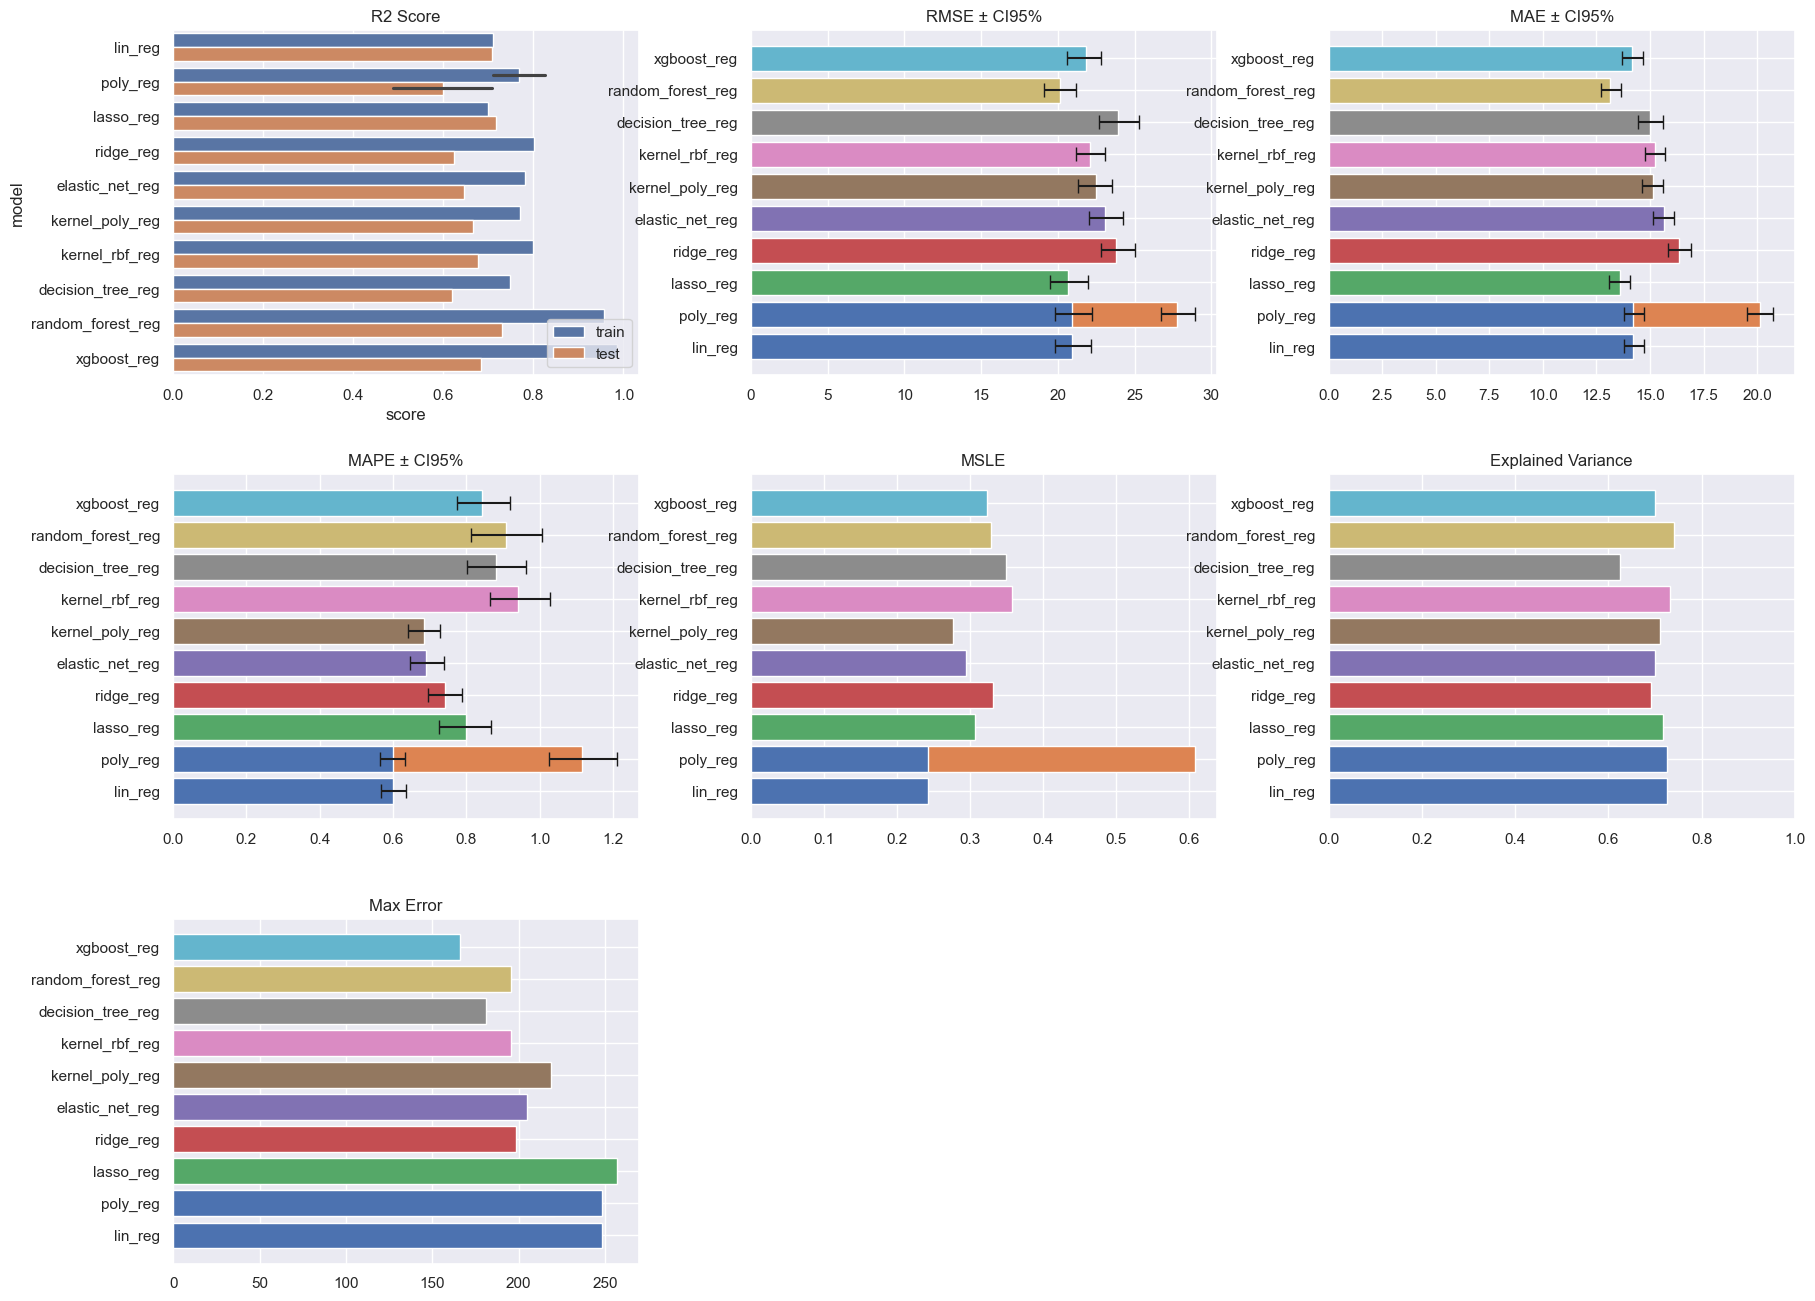

In [94]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'model','r2_train','r2_test',
        'rmse','rmse_low','rmse_high',
        'mae','mae_low','mae_high',
        'mape','mape_low','mape_high',
        'msle','explained_var','max_error'
    ]
)
plot_estimator_scores(estimator_scores_df)